In [1]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from transformers import BertForSequenceClassification, BertTokenizer
import torch.nn as nn
from torch.optim import AdamW
import functions_text_model as functions

c:\Users\celin\anaconda3\envs\DLproj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First we have to load the datasets, which have already been prepared in `data_labelling_json.ipynb`. The different datasets are:
- mixed_data: all utterances for which the speaker gender has been identified
- F_data: all utterances in which the speaker is a woman
- M_data: all utterances in which the speaker is a man

In [2]:
# Load the data from the JSON files
with open('cleaned_data.json') as file:
    mixed_data = json.load(file)

with open('F_data.json') as file:
    F_data = json.load(file)

with open('M_data.json') as file:
    M_data = json.load(file)

# Convert the data to lists of dictionaries
mixed_data = list(mixed_data.values())
F_data = list(F_data.values())
M_data = list(M_data.values())

Let's define some classes and functions needed in the training pipeline.

In [3]:
# Class for the PyTorch sarcasm detection Dataset
class SarcasmDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        utterance = item['utterance']
        sarcasm = int(item['sarcasm'])
        input_ids, attention_mask = encode_text(utterance)
        return input_ids.flatten(), attention_mask.flatten(), sarcasm


# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


# Function to encode the text
def encode_text(text):
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Input text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    return encoded_dict['input_ids'], encoded_dict['attention_mask']

We will now train 3 different models: 
- one model will be trained on all of the videos (video_files)
- one model will be trained on videos from female speakers only (F_videos)
- one model will be trained on videos from male speakers only (M_videos)

train Loss: 0.4932,  ACC: 0.7932, F1-weighted: 0.7897


100%|██████████| 2/2 [00:00<00:00, 14.44it/s]

eval Loss: 0.6589,  ACC: 0.6301, F1-weighted: 0.6184


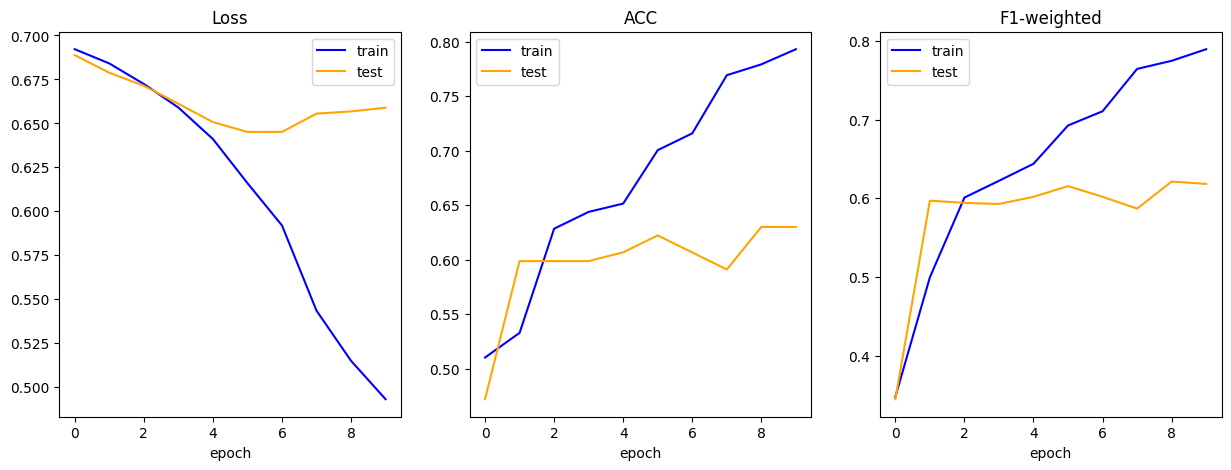

train loss [0.6921826004981995, 0.6840966194868088, 0.6724103912711143, 0.6590228080749512, 0.6411163806915283, 0.6160382926464081, 0.5919761136174202, 0.5435207970440388, 0.5149932466447353, 0.4931599348783493] test loss [0.6887949705123901, 0.6788183748722076, 0.6713883876800537, 0.6611726582050323, 0.6507459580898285, 0.6451365053653717, 0.6451697647571564, 0.655564159154892, 0.656815230846405, 0.6589075028896332]


In [6]:
# MIXED MODEL

# Set seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Set hyperparameters
learning_rate = 0.0001
num_epochs = 10
batch_size = 64
weight_decay = 0.05
dropout_prob = 0

# Split dataset into training and testing
dataset = SarcasmDataset(mixed_data)
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Initialize the dataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model
mixed_model = BertForSequenceClassification.from_pretrained(
    "prajjwal1/bert-tiny",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

mixed_model.classifier = nn.Sequential(
    nn.Dropout(dropout_prob),
    nn.Linear(in_features=128, out_features=64, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=64, out_features=16, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=16, out_features=2, bias=True)
    )

mixed_model.to(device)

# Define optimizer and criterion
optimizer = AdamW(mixed_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Define metrics
metrics = {'ACC': functions.acc, 'F1-weighted': functions.f1}

# Training loop
train_loss_log,  test_loss_log = [], []
metrics_names = list(metrics.keys())
train_metrics_log = [[] for i in range(len(metrics))]
test_metrics_log = [[] for i in range(len(metrics))]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    train_loss, train_metrics = functions.train_epoch(mixed_model, optimizer, criterion, metrics, train_dataloader, device)
    test_loss, test_metrics = functions.evaluate(mixed_model, criterion, metrics, test_dataloader, device)

    train_loss_log.append(train_loss)
    train_metrics_log = functions.update_metrics_log(metrics_names, train_metrics_log, train_metrics)

    test_loss_log.append(test_loss)
    test_metrics_log = functions.update_metrics_log(metrics_names, test_metrics_log, test_metrics)

    functions.plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)

print("train loss", train_loss_log, "test loss", test_loss_log)

# Save model
torch.save(mixed_model.state_dict(), 'models/mixed_model_text.pth')

train Loss: 0.6525,  ACC: 0.7301, F1-weighted: 0.7273


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


eval Loss: 0.6482,  ACC: 0.7073, F1-weighted: 0.7057


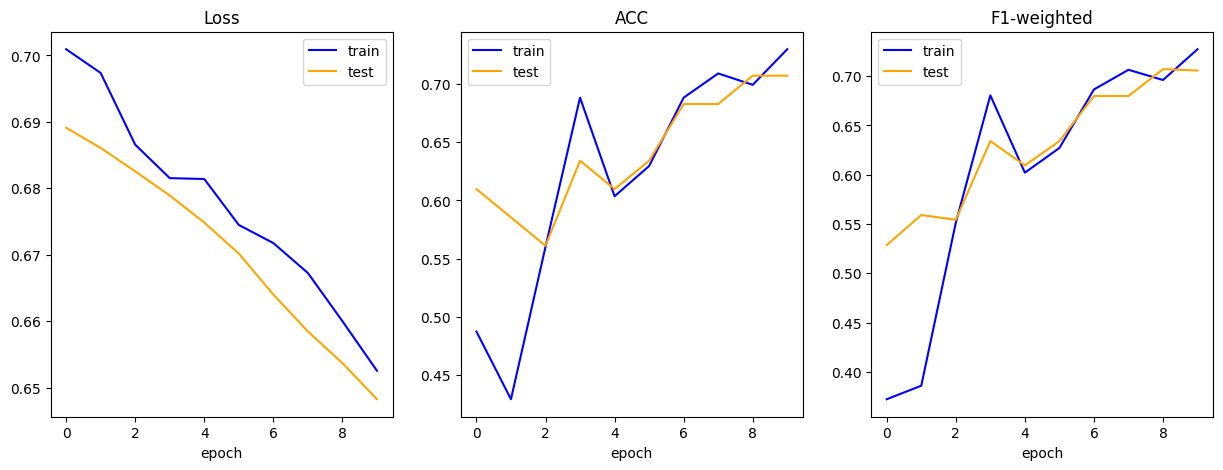

train loss [0.7009405891100565, 0.697364866733551, 0.6865685184796652, 0.6815324227015177, 0.6813989679018656, 0.6744796832402548, 0.6717539628346761, 0.667244553565979, 0.6599931120872498, 0.6525286634763082] test loss [0.6891149282455444, 0.6860727667808533, 0.6825537085533142, 0.678922176361084, 0.6748407483100891, 0.6701751351356506, 0.6639998555183411, 0.6584482192993164, 0.6536785364151001, 0.6482430100440979]


In [7]:
# FEMALE MODEL

# Set seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Set hyperparameters
learning_rate = 0.0001
num_epochs = 10
batch_size = 64
weight_decay = 0.05
dropout_prob = 0

# Split dataset into training and testing
dataset = SarcasmDataset(F_data)
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Initialize the dataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model
F_model = BertForSequenceClassification.from_pretrained(
    "prajjwal1/bert-tiny",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

F_model.classifier = nn.Sequential(
    nn.Dropout(dropout_prob),
    nn.Linear(in_features=128, out_features=64, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=64, out_features=16, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=16, out_features=2, bias=True)
    )

F_model.to(device)

# Define optimizer and criterion
optimizer = AdamW(F_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Define metrics
metrics = {'ACC': functions.acc, 'F1-weighted': functions.f1}

# Training loop
train_loss_log,  test_loss_log = [], []
metrics_names = list(metrics.keys())
train_metrics_log = [[] for i in range(len(metrics))]
test_metrics_log = [[] for i in range(len(metrics))]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    train_loss, train_metrics = functions.train_epoch(F_model, optimizer, criterion, metrics, train_dataloader, device)
    test_loss, test_metrics = functions.evaluate(F_model, criterion, metrics, test_dataloader, device)

    train_loss_log.append(train_loss)
    train_metrics_log = functions.update_metrics_log(metrics_names, train_metrics_log, train_metrics)

    test_loss_log.append(test_loss)
    test_metrics_log = functions.update_metrics_log(metrics_names, test_metrics_log, test_metrics)

    functions.plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)

print("train loss", train_loss_log, "test loss", test_loss_log)

# Save model
torch.save(F_model.state_dict(), 'models/F_model_text.pth')

train Loss: 0.5888,  ACC: 0.7561, F1-weighted: 0.7523


100%|██████████| 2/2 [00:00<00:00, 19.13it/s]


eval Loss: 0.6322,  ACC: 0.6605, F1-weighted: 0.6592


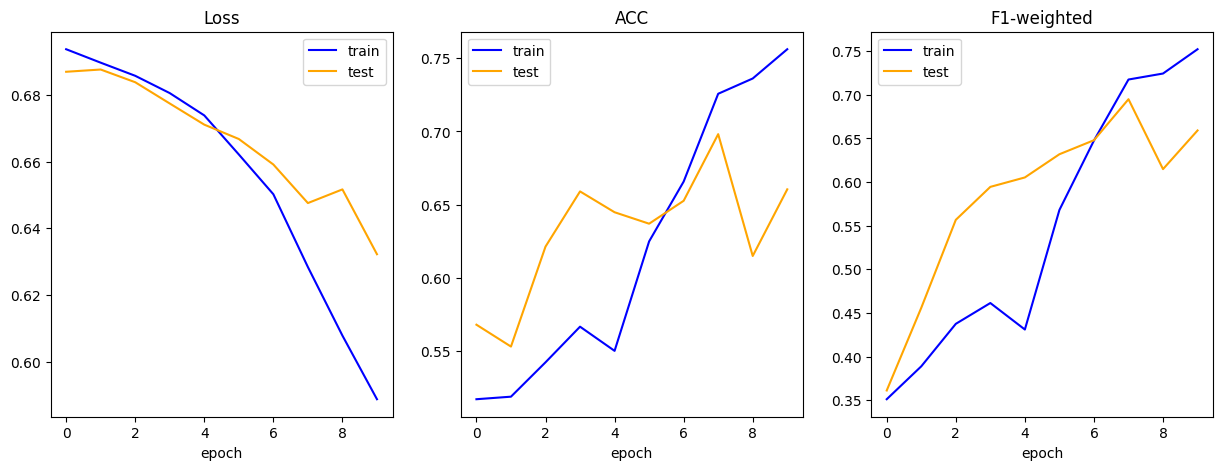

train loss [0.69363072514534, 0.6896028419335684, 0.6856741309165955, 0.6804906924565634, 0.6738102734088898, 0.6621153950691223, 0.6502039233843485, 0.6284065743287405, 0.6078717410564423, 0.5888223250706991] test loss [0.686878502368927, 0.6875528991222382, 0.6837457716464996, 0.6773781180381775, 0.67104572057724, 0.6667460203170776, 0.6591079831123352, 0.6475630700588226, 0.6516546905040741, 0.6322419941425323]


In [8]:
# MALE MODEL

# Set seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Set hyperparameters
learning_rate = 0.0001
num_epochs = 10
batch_size = 64
weight_decay = 0.05
dropout_prob = 0

# Split dataset into training and testing
dataset = SarcasmDataset(M_data)
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Initialize the dataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the model
M_model = BertForSequenceClassification.from_pretrained(
    "prajjwal1/bert-tiny",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

M_model.classifier = nn.Sequential(
    nn.Dropout(dropout_prob),
    nn.Linear(in_features=128, out_features=64, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=64, out_features=16, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=16, out_features=2, bias=True)
    )

M_model.to(device)

# Define optimizer and criterion
optimizer = AdamW(M_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Define metrics
metrics = {'ACC': functions.acc, 'F1-weighted': functions.f1}

# Training loop
train_loss_log,  test_loss_log = [], []
metrics_names = list(metrics.keys())
train_metrics_log = [[] for i in range(len(metrics))]
test_metrics_log = [[] for i in range(len(metrics))]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    train_loss, train_metrics = functions.train_epoch(M_model, optimizer, criterion, metrics, train_dataloader, device)
    test_loss, test_metrics = functions.evaluate(M_model, criterion, metrics, test_dataloader, device)

    train_loss_log.append(train_loss)
    train_metrics_log = functions.update_metrics_log(metrics_names, train_metrics_log, train_metrics)

    test_loss_log.append(test_loss)
    test_metrics_log = functions.update_metrics_log(metrics_names, test_metrics_log, test_metrics)

    functions.plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)

print("train loss", train_loss_log, "test loss", test_loss_log)

# Save model
torch.save(M_model.state_dict(), 'models/M_model_text.pth')